In [31]:
import numpy as np      
import pandas as pd     
import matplotlib.pyplot as plt
# %matplotlib inline
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
import re
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from imblearn.combine import SMOTETomek
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [2]:
a = pd.read_csv('/Users/kana/Desktop/nlp/project/CEAS_08.csv')
a.head(1)

,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1


In [3]:
body_df = a[['label','body']]
body_df.rename(columns={'label':'target','body':'message'}, inplace =True)
body_df.dropna(inplace=True)
body_df

/var/folders/fj/_pbd8nw171d7sx8h499n9r6w0000gn/T/ipykernel_62693/4124089714.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  body_df.rename(columns={'label':'target','body':'message'}, inplace =True)
/var/folders/fj/_pbd8nw171d7sx8h499n9r6w0000gn/T/ipykernel_62693/4124089714.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  body_df.dropna(inplace=True)


,target,message
0,1,"Buck up, your troubles caused by small dimensi..."
1,1,\nUpgrade your sex and pleasures with these te...
2,1,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...
3,0,Would anyone object to removing .so from this ...
4,1,\nWelcomeFastShippingCustomerSupport\nhttp://7...
...,...,...
39149,1,\n\nCNN Alerts: My Custom Alert\n\n\n\n\n\n\n ...
39150,1,\n\nCNN Alerts: My Custom Alert\n\n\n\n\n\n\n ...
39151,0,Hello there ! \nGreat work on the slide show v...
39152,0,"\nMail from sender , coming from intuit.com\ns..."


# Percentage of spam vs ham

In [164]:
values = body_df['target'].value_counts()
total = values.sum()
zero = values[0]/total*100
one = values[1]/total*100
zero

44.21515043162895

array([<Axes: ylabel='target'>], dtype=object)

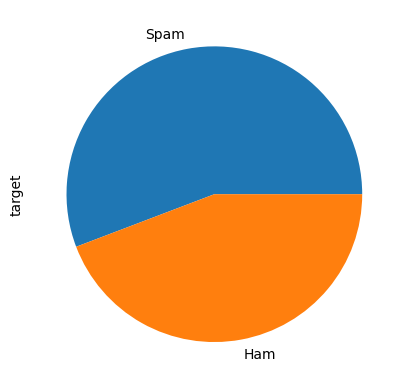

In [165]:
values.plot.pie(subplots=True,labels = ['Spam','Ham'])


# Data preprocessing

In [4]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def transform_text(text):
    # Lowercasing
    text = text.lower()
    
    # Replace URLs with a placeholder
    text = re.sub(r'http\S+|www\S+', 'URL', text)
    
    # Tokenization
    tokens = nltk.word_tokenize(text)
    
    # Remove non-alphanumeric characters but keep words
    tokens = [word for word in tokens if word.isalnum()]
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization 
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join back into a processed string
    return " ".join(tokens)

In [59]:
transform_text('''

Bolt rides are not only affordable, but they also come with a number of safety features.   
Here are some of the things we do to ensure your safety:  We train our drivers and verify their identity;
Our app has ‘Share your ETA’ and emergency assist buttons; We use rider feedback to improve future journeys.
Learn all about Bolt’s safety measures here.  OPEN THE APP  Safe travels! ?? 
The Bolt team  N.B. This is a limited-time offer that you can use from 2023-07-18 until 2023-07-24 in Nairobi,
Kenya. More information in the app. Discount is valid for up to 250 KES per trip.


''')

'bolt ride affordable also come number safety feature thing ensure safety train driver verify identity app share eta emergency assist button use rider feedback improve future journey learn bolt safety measure open app safe travel bolt team offer use nairobi kenya information app discount valid 250 kes per trip'

In [9]:
body_df['transformed_text'] = body_df['message'].apply(transform_text)
body_df

/var/folders/fj/_pbd8nw171d7sx8h499n9r6w0000gn/T/ipykernel_62693/792759156.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  body_df['transformed_text'] = body_df['message'].apply(transform_text)


,target,message,transformed_text
0,1,"Buck up, your troubles caused by small dimensi...",buck trouble caused small dimension soon becom...
1,1,\nUpgrade your sex and pleasures with these te...,upgrade sex pleasure technique URL
2,1,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,daily top 10 top video story aug 1 2008 pm edt...
3,0,Would anyone object to removing .so from this ...,would anyone object removing list tld basicall...
4,1,\nWelcomeFastShippingCustomerSupport\nhttp://7...,welcomefastshippingcustomersupport URL
...,...,...,...
39149,1,\n\nCNN Alerts: My Custom Alert\n\n\n\n\n\n\n ...,cnn alert custom alert alert name custom alert...
39150,1,\n\nCNN Alerts: My Custom Alert\n\n\n\n\n\n\n ...,cnn alert custom alert alert name custom alert...
39151,0,Hello there ! \nGreat work on the slide show v...,hello great work slide show viewer application...
39152,0,"\nMail from sender , coming from intuit.com\ns...",mail sender coming server 169 170 subject turb...


In [28]:
ham_carpos = []
for sentence in body_df[body_df['target'] == 0]['transformed_text'].tolist():
    for word in sentence.split():
        ham_carpos.append(word)
        
spam_carpos = []
for sentence in body_df[body_df['target'] == 1]['transformed_text'].tolist():
    for word in sentence.split():
        spam_carpos.append(word)        

        

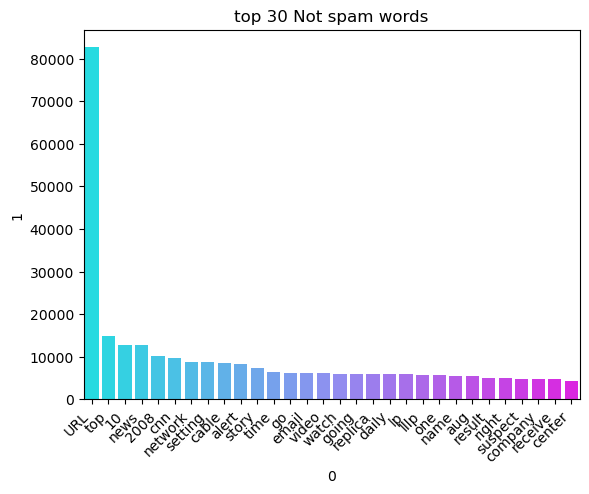

In [29]:
filter_ham_df = pd.DataFrame(Counter(spam_carpos).most_common(30))
filter_spam_df = pd.DataFrame(Counter(ham_carpos).most_common(30))

sns.barplot(data = filter_ham_df, x = filter_ham_df[0], y = filter_ham_df[1], palette = 'cool')
plt.title('top 30 Not spam words')
plt.xticks(rotation=45, ha='right')
plt.show()


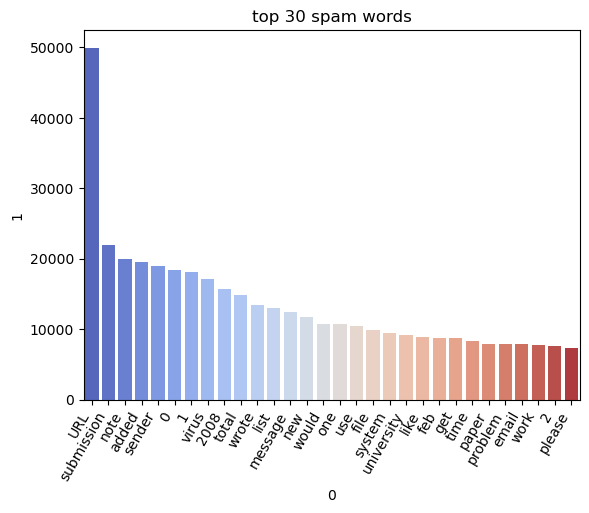

In [30]:
sns.barplot(data = filter_ham_df, x = filter_spam_df[0], y = filter_spam_df[1], palette = 'coolwarm')
plt.title('top 30 spam words')
plt.xticks(rotation=60, ha='right')
plt.show()

# New choosing classifier

In [11]:
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features = 3000)


# define target and features
X = tfidf.fit_transform(body_df['transformed_text']).toarray()
y = body_df['target'].values.ravel()

# train test split

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

#classifiers
svc = SVC(kernel="sigmoid", gamma=1.0, probability = True)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50, random_state=2)

# Dictionary for classifiers
models = {
    'SVC': svc,
    'KNN': knc,
    'NB': mnb,
    'DT': dtc,
    'LR': lrc,
    'RF': rfc,
    'Adaboost': abc,
    'Bagging': bc,
    'ETC': etc,
    'GBDT': gbdt,
}

In [176]:
def train_classifier(model, X_train, y_train, X_test, y_test):
    """Train model and evaluate performance"""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Standard classification metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # Instead of passing model.predict_proba(X_test) directly:
    y_proba = model.predict_proba(X_test)

    # For binary classification, use the probability of the positive class:
    if y_proba.shape[1] == 2:
        y_proba = y_proba[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    
    cm = confusion_matrix(y_test, y_pred)  # Confusion Matrix
    
    # Calculate support (number of occurrences of each class in the true responses)
    support = np.sum(cm, axis=1)
    
    return acc, prec, rec, f1, auc, cm, support

# Create lists to store the results
results = []

for name, model in models.items():
    print(f"\nTraining: {name}")
    try:
        # Train and evaluate classifier
        acc, prec, rec, f1, auc, cm, support = train_classifier(model, X_train, y_train, X_test, y_test)
        
        # Store the metrics in the results list
        results.append({
            'Model': name,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1 Score': f1,
            'AUC': auc,
            'Support': support
        })
        
        # Print metrics
        print(f"Accuracy: {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall: {rec:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"AUC: {auc:.4f}")
        print(f"Confusion Matrix:\n{cm}")
        print(f"Support: \nClass 0: {support[0]} \nClass 1: {support[1]}")
        
    except Exception as e:
        print(f"Error in {name}: {e}")

# Convert results into DataFrame for better comparison
results_df = pd.DataFrame(results)

# Sort results by F1 Score or any other metric that fits your needs
results_df = results_df.sort_values(by='F1 Score', ascending=False)

print("\nComparison of Classifiers:")
print(results_df)



Training: SVC
Accuracy: 0.9736
Precision: 0.9736
Recall: 0.9736
F1 Score: 0.9736
AUC: 0.9893
Confusion Matrix:
[[3362  120]
 [  87 4262]]
Support: 
Class 0: 3482 
Class 1: 4349

Training: KNN
Accuracy: 0.7648
Precision: 0.8341
Recall: 0.7648
F1 Score: 0.7432
AUC: 0.8956
Confusion Matrix:
[[1643 1839]
 [   3 4346]]
Support: 
Class 0: 3482 
Class 1: 4349

Training: NB
Accuracy: 0.9590
Precision: 0.9618
Recall: 0.9590
F1 Score: 0.9591
AUC: 0.9973
Confusion Matrix:
[[3464   18]
 [ 303 4046]]
Support: 
Class 0: 3482 
Class 1: 4349

Training: DT
Accuracy: 0.9215
Precision: 0.9287
Recall: 0.9215
F1 Score: 0.9205
AUC: 0.9162
Confusion Matrix:
[[2905  577]
 [  38 4311]]
Support: 
Class 0: 3482 
Class 1: 4349

Training: LR
Accuracy: 0.9865
Precision: 0.9865
Recall: 0.9865
F1 Score: 0.9865
AUC: 0.9989
Confusion Matrix:
[[3419   63]
 [  43 4306]]
Support: 
Class 0: 3482 
Class 1: 4349

Training: RF
Accuracy: 0.9891
Precision: 0.9892
Recall: 0.9891
F1 Score: 0.9891
AUC: 0.9993
Confusion Matrix:
[[

Top-left: True negatives (non-spam correctly identified).
Top-right: False positives (non-spam incorrectly flagged as spam).
Bottom-left: False negatives (spam that was missed).
Bottom-right: True positives (spam correctly identified).
#from sklearn.metrics import ConfusionMatrixDisplay

#  for classifying messages

In [14]:
# Vectorize the text
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2), stop_words='english')
X = tfidf.fit_transform(body_df['transformed_text']).toarray()
y = body_df['target'].values

In [25]:
# Cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = ExtraTreesClassifier(n_estimators= 150, min_samples_split=2, min_samples_leaf=1, max_depth=45, criterion='entropy', random_state=2)



accuracies = []
for train_index, test_index in skf.split(X, y):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_test_fold)

    acc = accuracy_score(y_test_fold, y_pred)
    accuracies.append(acc)

print(f"Average Accuracy across folds: {np.mean(accuracies):.4f}")

Average Accuracy across folds: 0.9809


In [58]:
# **Making a New Prediction**
new_text = ['''
Hi,    Thank you for your interest in joining Appen! This email is to officially invite you to a NEW Project on Appen 9 Platform A5655?Request detail 27?Asia Image Collection Project.    To apply for this project, click here to log on Appen Connect, then click here (project link) to opt in to China platform by still using your Appen Connect email address and password.  Your payment will be processed through Appen Connect to your Payoneer account after your work is accepted.    Project Overview:  You are invited to participate in a new image collection and annotation project. We are actively seeking participants who are interested in being the image subjects.  The project seeks to build a large set of annotated images to help machine learning (ML) and artificial intelligence (AI) systems perform more fairly and ethically across a diverse range of people. By participating in this project, your image, demographics, and related annotations (“Your Data”) may be shared publicly so that the broader AI community may develop, train, and evaluate ML and AI software, algorithms, and other technologies. This means that your images would be individually viewable among several thousand other images in the dataset. In addition, your data and images could be published in various media in connection with promotions or publications related to the image dataset. For example, your image could be used as a sample image in an academic paper related to the image dataset or in a blog post or presentation promoting the dataset. Your name and email address will not be shared publicly, and individuals accessing the image set will be contractually. restricted from attempting to re-identify you, along with other reasonable use restrictions.  To participate as an image subject, you must:  ? Provide 10 different images of yourself in different poses and attire with a minimum of 1  day between each image  ? Provide self-reported demographics (e.g., ancestry, pronoun, nationality, country of  residence, age)  ? Provide images taken with a smartphone, DSLR camera, or compact camera with at  least 8-megapixels, manufactured after 2011.  ? Read and agree to the project’s informed consent form  ? Be at least the age of majority where you reside.  We are looking to pay a range of 3 ($)/row.  Kindly wait for the Project team email as they will reach out to those who will be considered to work on their project.  Note: Sharing photos and other information online is fairly commonplace, however, it’s important to remember the risks when allowing Your Data to be shared online. Once Your Data is made public, it could possibly be used for unauthorized or unintended purposes, such as catfishing or deep fakes or sold to third parties for various purposes, such as targeted advertising or other commercial or political activities. It's important to carefully consider the potential risks before participating in this project.    Project Opt In Guidelines: https://connect.appen.com/qrp/public-files/emails/2023/06/A5655_Image_Collection_NEW_v2.pdf    To find out more about this project or if you have any questions/issues, please contact the project support - yuyang@appen.com with email subject: “A5655?Request detail 27?Asia Image Collection Project”.    We are extremely excited to have you join the Appen 9 Crowd and participate in the Project!    Kind regards,  Appen 9 Support Team  If you have any questions or concerns about this message, please contact support.

            ''']
new_text_tfidf = tfidf.transform(new_text).toarray()  

prediction = model.predict(new_text_tfidf)
print(f"Prediction: {'Spam' if prediction[0] == 1 else 'Not Spam'}")

#probability score for spam:
spam_probability = model.predict_proba(new_text_tfidf)[0][1]
print(f"Spam Probability: {spam_probability:.4f}")


Prediction: Not Spam
Spam Probability: 0.1422


In [53]:
prediction[0]

1

# Hyperparameter tuning

In [225]:
ExtraTreesClassifier??

In [22]:
# Define constants
RANDOM_STATE = 42
N_JOBS = -1   # Use all available cores
VERBOSE = 1   # Controls verbosity

# Initialize the ExtraTreesClassifier
etc_clf = ExtraTreesClassifier(random_state=RANDOM_STATE)

# Define parameter grid for tuning
param_dist = {
    'n_estimators': np.arange(50, 1001, 50),              # Number of trees in the forest
    'max_depth': [None] + list(np.arange(5, 51, 5)),       # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],                       # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],                         # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2', None, 0.2, 0.5, 0.8], # Number of features to consider when looking for the best split
    'criterion': ['gini', 'entropy'],                    # Function to measure the quality of a split
    'class_weight': [None, 'balanced']                   # Handle class imbalance
}

# Assuming X_train_fold and y_train_fold are already defined,
# create a smaller subset for quick tuning.
X_small = X_train_fold[:10000]
y_small = y_train_fold[:10000]

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=etc_clf,
                                   param_distributions=param_dist,
                                   n_iter=10,    # Number of parameter settings sampled
                                   cv=3,         # 3-fold cross-validation
                                   verbose=VERBOSE,
                                   n_jobs=N_JOBS,
                                   random_state=RANDOM_STATE)

# Fit the model on the subset of data
random_search.fit(X_small, y_small)

# Output the best parameters and corresponding score
print("Best Parameters from RandomizedSearchCV:")
print(random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)



Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters from RandomizedSearchCV:
{'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 45, 'criterion': 'entropy', 'class_weight': None}
Best Cross-Validation Score: 0.9780000795520464
